In [1]:
using StatsPlots, DataFrames, Statistics, GLM
import CSV

In [44]:
function add_log_colsumns!(df::DataFrame)
    df.R_log = log.(df.R)
    df.R_log_err = (df.R * 0.008 .+ 0.01) ./ df.R
    df.R_err = (df.R * 0.008 .+ 0.01)
    df.T_kelvins = df.T .+ 273.15
    df.one_over_T = 1 ./ df.T_kelvins
    df.one_over_T_err = df.T_kelvins .^ (-2)
    return nothing
end

add_log_colsumns! (generic function with 1 method)

In [45]:
dfh = CSV.read("data/data_heating.csv", DataFrame);
dfc = CSV.read("data/data_cooling.csv", DataFrame);
add_log_colsumns!(dfh)
add_log_colsumns!(dfc)

In [4]:
olsh = lm(@formula(U ~ T), dfh)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

U ~ 1 + T

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.179672   0.0202068     -8.89    <1e-10  -0.220578   -0.138765
T             0.0417525  0.000318805  130.97    <1e-51   0.0411071   0.0423979
──────────────────────────────────────────────────────────────────────────────

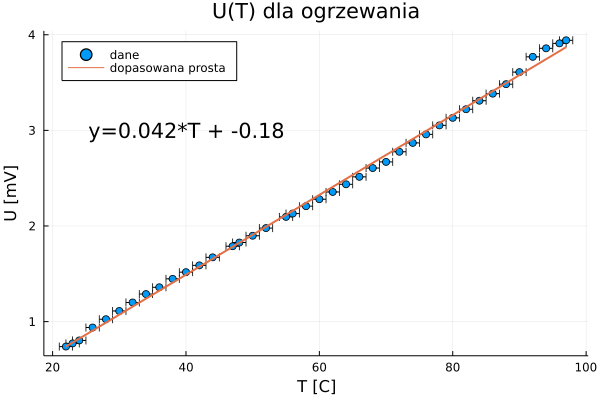

In [5]:
@df dfh scatter(:T, :U, label="dane", legend=:topleft, yerror=(:U * (0.06/100)), xerror=1, dpi=300)
plot!(dfh.T,predict(olsh), label="dopasowana prosta", lw=2)
xlabel!("T [C]")
ylabel!("U [mV]")
title!("U(T) dla ogrzewania")
annotate!(40, 3, "y=$(round(coef(olsh)[2], digits=3))*T + $(round(coef(olsh)[1], digits=3))")
#savefig("rysunki/ut-ogrzewanie.png")

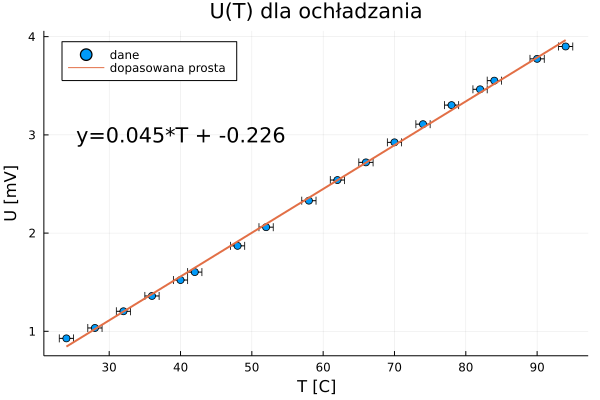

In [55]:
dfc_termopara = dropmissing(dfc, :U)
olsc = lm(@formula(U ~ T), dfc_termopara)
@df dfc_termopara scatter(:T, :U, label="dane", legend=:topleft, yerror=(:U * (0.06/100)), xerror=1, dpi=300)
plot!(dfc_termopara.T,predict(olsc), label="dopasowana prosta", lw=2)
xlabel!("T [C]")
ylabel!("U [mV]")
title!("U(T) dla ochładzania")
annotate!(40, 3, "y=$(round(coef(olsc)[2], digits=3))*T + $(round(coef(olsc)[1], digits=3))")
#savefig("rysunki/ut-ochladzanie.png")

In [7]:
olsc

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

U ~ 1 + T

Coefficients:
──────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.225757   0.0276288     -8.17    <1e-06  -0.284327   -0.167186
T             0.0445855  0.000440561  101.20    <1e-23   0.0436515   0.0455194
──────────────────────────────────────────────────────────────────────────────

In [30]:
olsr = lm(@formula(R_log ~ one_over_T), dfh; wts=(dfh.R_log_err .^ -2))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

R_log ~ 1 + one_over_T

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error          t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   -10.9632  0.00102994  -10644.46    <1e-99   -10.9652   -10.9612
one_over_T   3934.72    0.329025     11958.72    <1e-99  3934.08    3935.37
─────────────────────────────────────────────────────────────────────────────

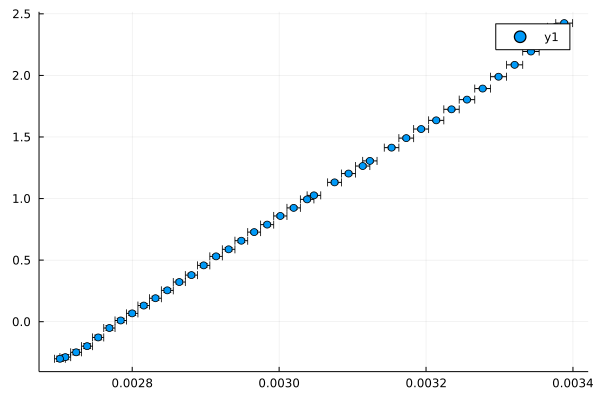

In [17]:
@df dfh scatter(:one_over_T, :R_log, yerror=(:R_log_err), xerror=(:one_over_T_err))

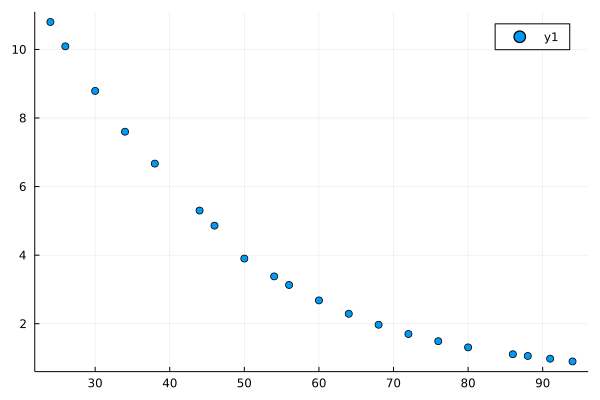

In [46]:
dfc_r = dropmissing(dfc, :R);
@df dfc_r scatter(:T, :R)

In [29]:
olsr = lm(@formula(R_log ~ one_over_T), dfc_r; wts=(dfc_r.R_log_err .^ -2))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

R_log ~ 1 + one_over_T

Coefficients:
────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   -11.0051  0.00175723  -6262.77    <1e-99   -11.0085   -11.0017
one_over_T   3996.49    0.563867     7087.64    <1e-99  3995.38    3997.59
────────────────────────────────────────────────────────────────────────────

In [31]:
exp(-11.0051)

1.6616738953054937e-5

In [32]:
exp(-10.9632)

1.732777244509747e-5

In [33]:
kb = 1.38e-23;

In [34]:
3996.49 * 2 *kb

1.10303124e-19

In [36]:
0.55 * 2 * kb

1.5180000000000003e-23

In [37]:
3934.72 * 2 *kb

1.08598272e-19

In [38]:
0.33 * 2 * kb

9.108000000000001e-24

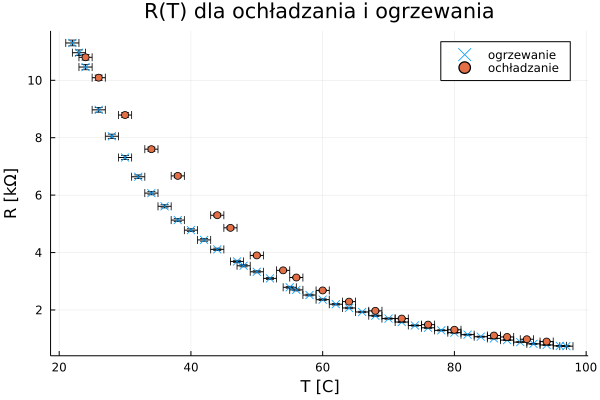

In [70]:
@df dfh scatter(:T, :R, marker=:x, label="ogrzewanie", yerror=:R_err, xerror=1, dpi=300)
@df dfc_r scatter!(:T, :R, label="ochładzanie", yerror=:R_err, xerror=1)
title!("R(T) dla ochładzania i ogrzewania")
xlabel!("T [C]")
ylabel!("R [kΩ]")
#savefig("rysunki/r-od-t.png")

In [56]:
describe(dfh)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,T,59.1,22,59.0,97,0,Int64
2,U,2.2879,0.739,2.2435,3.942,0,Float64
3,R,3.5655,0.74,2.44,11.3,0,Float64
4,R_log,0.938884,-0.301105,0.89146,2.4248,0,Float64
5,R_log_err,0.0132902,0.00888496,0.0121028,0.0215135,0,Float64
6,R_err,0.038524,0.01592,0.02952,0.1004,0,Float64
7,T_kelvins,332.25,295.15,332.15,370.15,0,Float64
8,one_over_T,0.0030242,0.00270161,0.00301072,0.00338811,0,Float64
9,one_over_T_err,9.18971e-6,7.29868e-6,9.06449e-6,1.14793e-5,0,Float64


In [57]:
(3.942 - 0.739) / (97-22)

0.04270666666666667

In [61]:
0.739 - (3.942 - 0.739) / (98-21) * 21

-0.13454545454545452

In [62]:
0.739 - (3.93 - 0.74) / (98-21) * 21

-0.13100000000000012